# Imports

In [59]:
from typing import List
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, RocCurveDisplay

# Data loading and preprocessing

## Train

In [15]:
events = pd.read_csv("../data/events_train.csv", parse_dates=True)
counters_train = pd.read_csv("../data/counters_train.csv", parse_dates=True)

In [16]:
counters_in = counters_train[counters_train.direction == 'in'][['dt', 'cnt']]
counters_out = counters_train[counters_train.direction == 'out'][['dt', 'cnt']]
counters_in['dt'] = counters_in.dt.apply(pd.to_datetime)
counters_out['dt'] = counters_out.dt.apply(pd.to_datetime)
counters_in = counters_in.set_index('dt')
counters_out = counters_out.set_index('dt')

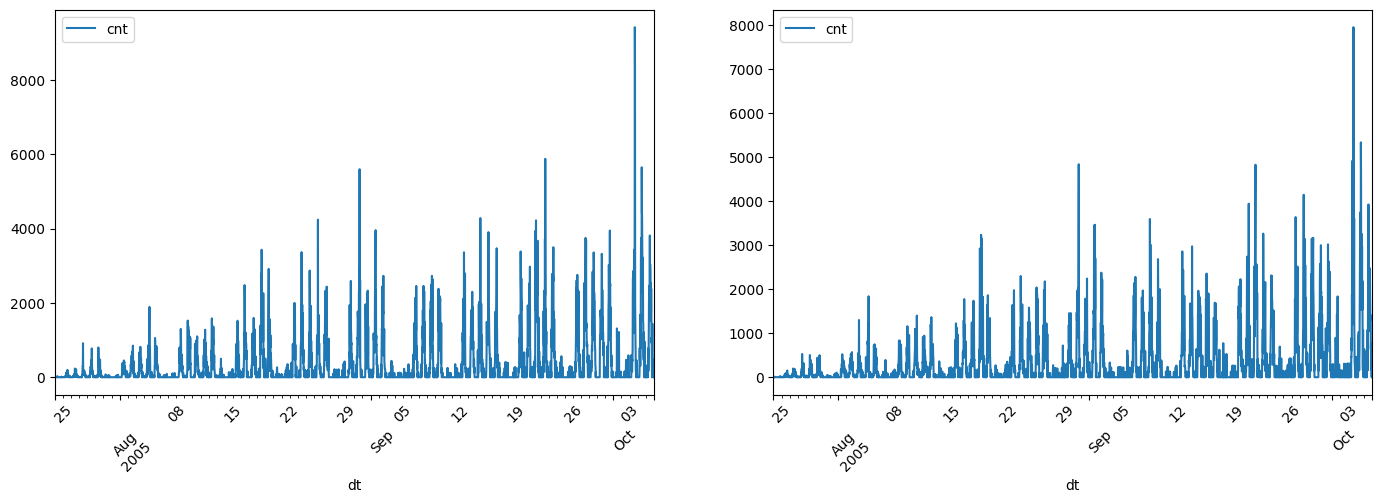

In [17]:
fig, ax = plt.subplots(1,2, figsize=(17, 5))
counters_in.plot(rot=45, ax=ax[0])
counters_out.plot(rot=45, ax=ax[1])
plt.show()

<AxesSubplot: xlabel='cnt', ylabel='Count'>

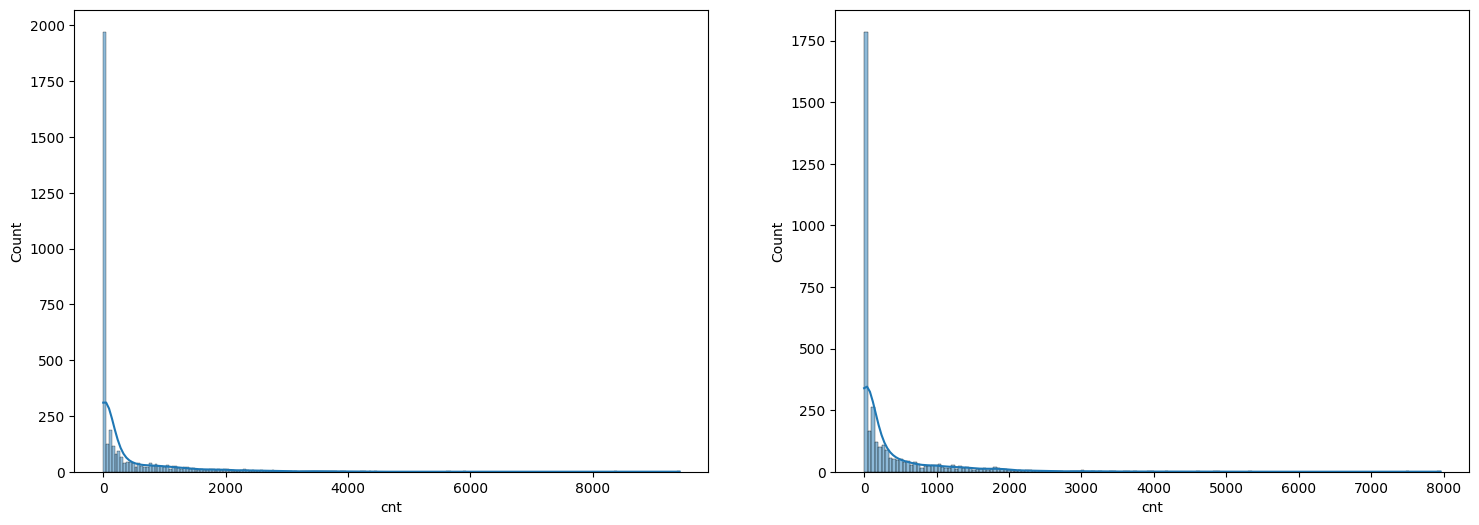

In [18]:
fig, ax = plt.subplots(1,2, figsize=(18, 6))
sns.histplot(counters_in.cnt, kde=True, ax=ax[0])
sns.histplot(counters_out.cnt, kde=True, ax=ax[1])

In [19]:
counters_in = counters_in.asfreq(freq='30min')
counters_out = counters_out.asfreq(freq='30min')

In [20]:
def accumulate_flow(feature:pd.Series) -> List[int]:
    accumulator = []
    cumulative_sum = 0
    
    for flow in feature:
        cumulative_sum += flow
        accumulator.append(cumulative_sum)
        
    return accumulator

In [21]:
counters_in['cumulative_flow'] = accumulate_flow(counters_in.cnt)
counters_out['cumulative_flow'] = accumulate_flow(counters_out.cnt)

In [22]:
counters_train = pd.DataFrame(columns=['dt', 'cnt'])

counters_train['dt'] = counters_in.index
counters_train['cnt'] = counters_in.cumulative_flow.values - counters_out.cumulative_flow.values

counters_train = counters_train.set_index('dt')

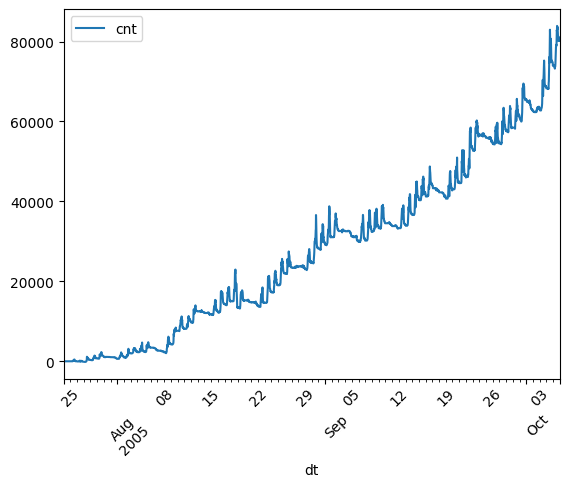

In [23]:
counters_train.plot(rot=45);

In [24]:
counters_train = counters_train.asfreq(freq='30min')

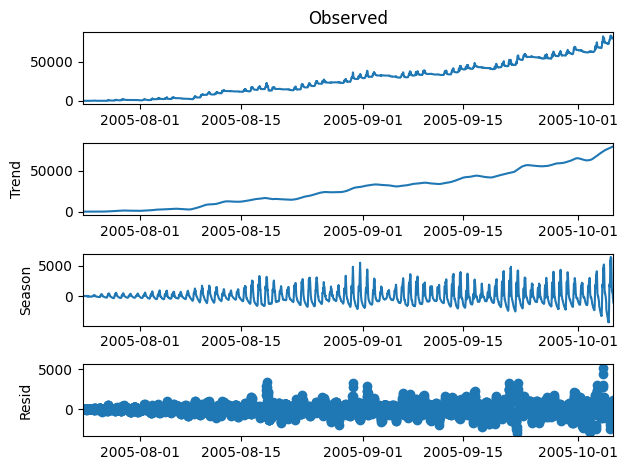

In [25]:
stl_res = STL(counters_train, period=24*2).fit()
stl_res.plot();

In [26]:
events.head(5)

,dt_start,dt_end,event_type
0,2005-07-26 11:00:00,2005-07-26 14:00:00,event
1,2005-07-29 08:00:00,2005-07-29 11:00:00,event
2,2005-08-02 15:30:00,2005-08-02 16:30:00,event
3,2005-08-04 16:30:00,2005-08-04 17:30:00,event
4,2005-08-05 08:00:00,2005-08-05 11:00:00,event


In [27]:
def check_if_event(timestamp) -> int:
    for i in range(len(events)):
        if events.iloc[i]['dt_start'] <= timestamp <= events.iloc[i]['dt_end']:
            return 1
    return 0

In [28]:
events['dt_start'] = events.dt_start.apply(pd.to_datetime)
events['dt_end'] = events.dt_end.apply(pd.to_datetime)

In [30]:
train_dataset = pd.DataFrame(columns=['dt', 'seasonal_feature', 'event'])

train_dataset['dt'] = counters_train.index
train_dataset['seasonal_feature'] = stl_res.seasonal.values
train_dataset['event'] = train_dataset.dt.apply(check_if_event)

train_dataset = train_dataset.set_index('dt')

In [31]:
train_dataset.head(5)

,seasonal_feature,event
dt,,
2005-07-24 00:00:00,38.753205,0
2005-07-24 00:30:00,27.404192,0
2005-07-24 01:00:00,31.296331,0
2005-07-24 01:30:00,31.883614,0
2005-07-24 02:00:00,32.085104,0


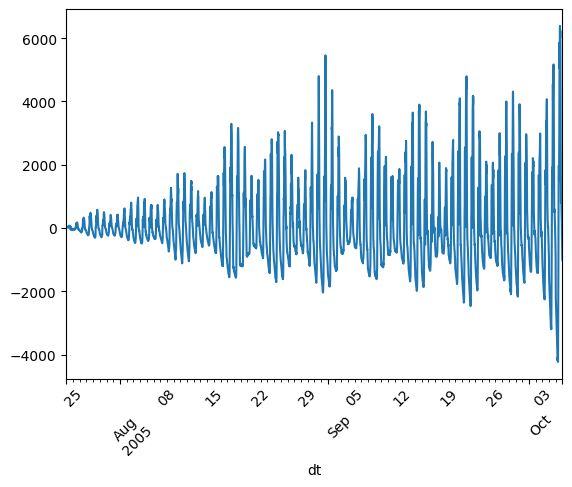

In [32]:
train_dataset.seasonal_feature.plot(rot=45);

In [53]:
x_train, y_train = train_dataset['seasonal_feature'].values.reshape(-1, 1), train_dataset['event'].values.reshape(-1, 1)

In [54]:
x_train.shape, y_train.shape

((3552, 1), (3552, 1))

## Test

In [35]:
counters_test = pd.read_csv("../data/counters_test.csv", parse_dates=True)
events = pd.read_csv("../data/events_test.csv", parse_dates=True)

In [36]:
events['dt_start'] = events.dt_start.apply(pd.to_datetime)
events['dt_end'] = events.dt_end.apply(pd.to_datetime)

In [37]:
counters_test['dt'] = counters_test.dt.apply(pd.to_datetime)
counters_test_in = counters_test[counters_test.direction == 'in'][['dt', 'cnt']]
counters_test_out = counters_test[counters_test.direction == 'out'][['dt', 'cnt']]
counters_test_in = counters_test_in.set_index('dt')
counters_test_out = counters_test_out.set_index('dt')

In [38]:
counters_test_in['cumulative_flow'] = accumulate_flow(counters_test_in.cnt)
counters_test_out['cumulative_flow'] = accumulate_flow(counters_test_out.cnt)

In [39]:
counters_test = pd.DataFrame(columns=['dt', 'cnt'])

counters_test['dt'] = counters_test_in.index
counters_test['cnt'] = counters_test_in.cumulative_flow.values - counters_test_out.cumulative_flow.values

counters_test = counters_test.set_index('dt')

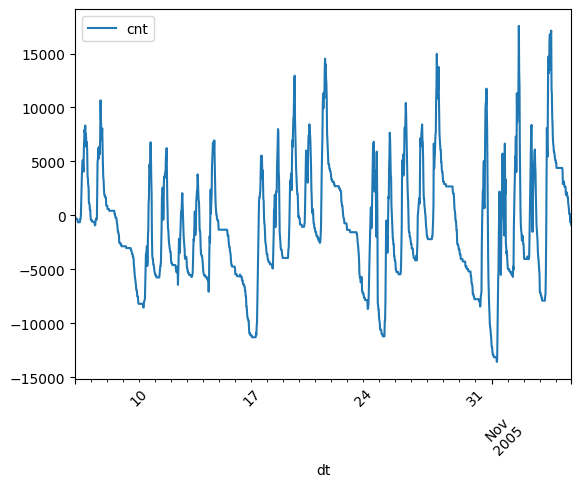

In [40]:
counters_test.plot(rot=45);

In [41]:
counters_test = counters_test.asfreq("30min")

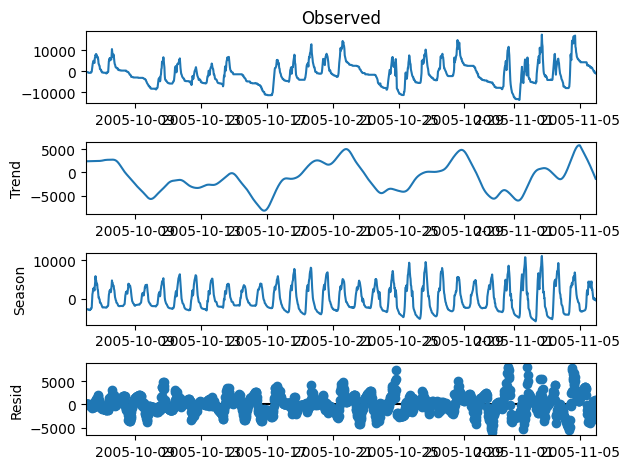

In [42]:
stl_res = STL(counters_test, period=24*2).fit()
stl_res.plot();

In [43]:
test_dataset = pd.DataFrame(columns=['dt', 'seasonal_feature', 'event'])

test_dataset['dt'] = counters_test.index
test_dataset['seasonal_feature'] = stl_res.seasonal.values
test_dataset['event'] = test_dataset.dt.apply(check_if_event)

test_dataset = test_dataset.set_index("dt")

In [44]:
test_dataset.head(5)

,seasonal_feature,event
dt,,
2005-10-06 00:00:00,-2639.720396,0
2005-10-06 00:30:00,-2771.778570,0
2005-10-06 01:00:00,-2760.978257,0
2005-10-06 01:30:00,-2810.671637,0
2005-10-06 02:00:00,-2790.854344,0


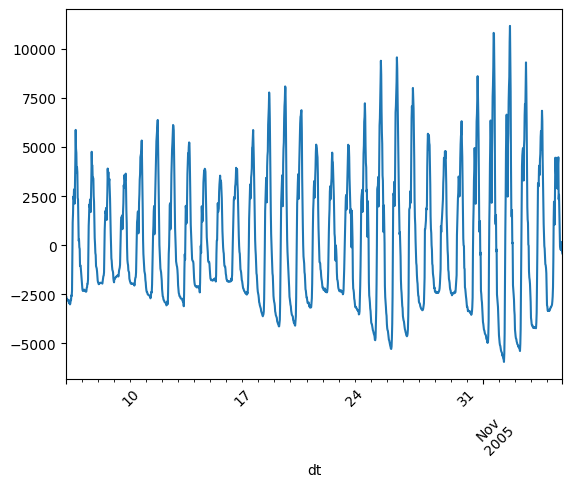

In [45]:
test_dataset.seasonal_feature.plot(rot=45);

In [52]:
x_test, y_test = test_dataset['seasonal_feature'].values.reshape(-1, 1), test_dataset['event'].values.reshape(-1, 1)

# Building and fitting model for event prediction

In [70]:
catboost = CatBoostClassifier(depth=7)

catboost.fit(x_train, y_train, 
             eval_set=(x_test, y_test))

Learning rate set to 0.043339
0:	learn: 0.6243066	test: 0.6185986	best: 0.6185986 (0)	total: 1.26ms	remaining: 1.26s
1:	learn: 0.5656309	test: 0.5555163	best: 0.5555163 (1)	total: 2.28ms	remaining: 1.14s
2:	learn: 0.5137416	test: 0.4993160	best: 0.4993160 (2)	total: 3.26ms	remaining: 1.08s
3:	learn: 0.4691827	test: 0.4492877	best: 0.4492877 (3)	total: 4.22ms	remaining: 1.05s
4:	learn: 0.4305878	test: 0.4134552	best: 0.4134552 (4)	total: 5.31ms	remaining: 1.06s
5:	learn: 0.3969969	test: 0.3776931	best: 0.3776931 (5)	total: 6.41ms	remaining: 1.06s
6:	learn: 0.3681236	test: 0.3495119	best: 0.3495119 (6)	total: 7.41ms	remaining: 1.05s
7:	learn: 0.3429551	test: 0.3258522	best: 0.3258522 (7)	total: 8.48ms	remaining: 1.05s
8:	learn: 0.3218695	test: 0.3055350	best: 0.3055350 (8)	total: 9.45ms	remaining: 1.04s
9:	learn: 0.3029705	test: 0.2878483	best: 0.2878483 (9)	total: 10.6ms	remaining: 1.05s
10:	learn: 0.2867883	test: 0.2727961	best: 0.2727961 (10)	total: 11.6ms	remaining: 1.04s
11:	learn: 

# Event prediction model evaluation and metrics

In [71]:
x_test.shape, y_test.shape

((1488, 1), (1488, 1))

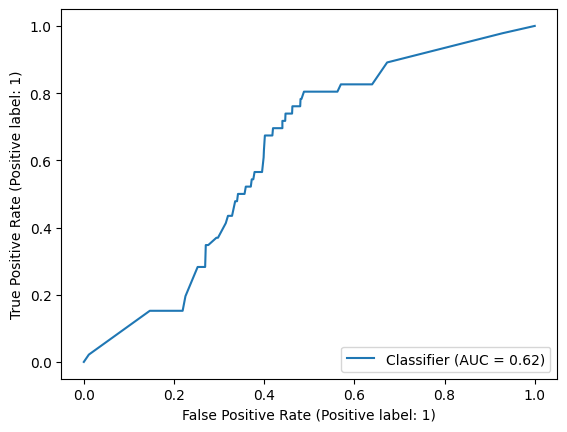

In [72]:
RocCurveDisplay.from_predictions(y_test, preds)

In [65]:
train_dataset.event.value_counts()

0    3392
1     160
Name: event, dtype: int64